In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bnn_shson_rhograd import *
import nn_shson
from shson_exp_manager import *
import h5py
import random

%matplotlib inline


In [2]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [3]:
mnist = h5py.File('mnist.hdf5', 'r')

random.seed(1337)

perm1 = range(784)
perm2 = range(784)

random.shuffle(perm1)
random.shuffle(perm2)

print perm1[0:20]
print perm2[0:20]

x_train = list()
x_valid = list()
x_test = list()

x_train.append(mnist['train_data'][()])
x_train.append(mnist['train_data'][()][:, perm1])
x_train.append(mnist['train_data'][()][:, perm2])
t_train = num_to_onehot(mnist['train_label'][()], 10)
x_valid.append(mnist['valid_data'][()])
x_valid.append(mnist['valid_data'][()][:, perm1])
x_valid.append(mnist['valid_data'][()][:, perm2])
t_valid = num_to_onehot(mnist['valid_label'][()], 10)
x_test.append(mnist['test_data'][()])
x_test.append(mnist['test_data'][()][:, perm1])
x_test.append(mnist['test_data'][()][:, perm2])
t_test = num_to_onehot(mnist['test_label'][()], 10)

mnist.close()


[290, 476, 531, 412, 667, 470, 656, 123, 167, 378, 357, 729, 324, 327, 271, 681, 155, 75, 755, 316]
[398, 598, 337, 481, 192, 554, 297, 296, 157, 72, 29, 778, 513, 407, 264, 420, 69, 508, 690, 504]


In [4]:
batch_size = 200

# Blundell version

In [8]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [9]:
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-1.0, 5.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = True, train_rho = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')


layer done
layer done
(10, ?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [10]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 100
n_batches = len(t_train) / batch_size

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()

for ep in range(n_epochs):
    bnn.reset_klrw()
    
    for i in range(n_batches):
        bnn.decay_klrw()
#         if (i+1) % 20 == 0:
#             print("klrw index : %g"%(bnn.get_klrw()))
        
        feed = {bnn.x: x_train[i*batch_size:(i+1)*batch_size], \
                bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

        
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)
        
#         if i > 50 and np.mean(fs[-50:-25]) < np.mean(fs[-25:]):
#             bnn.decay_lr()
#             print ("--- learning rate decayed : %g ---"%(bnn.get_lr()))
        
            

        if i%50 == 0:
            train_accuracy = bnn.validate(feed)

            print("ep %d, step %d, training accuracy %g"%(ep, i, train_accuracy))
            print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))
            #print v_q - v_p + v_l

        bnn.train(feed)
    
    vacc = bnn.validate({bnn.x: x_valid, bnn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    
    summary = sess.run(merged, feed_dict ={bnn.x: x_valid, bnn.t: t_valid})
    test_writer.add_summary(summary, ep)
    
    print("valid accuracy %g"%vacc)
    
    if ep > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
        bnn.decay_lr()
        print ("--- learning rate decayed : %g ---"%(bnn.get_lr()))
    



ep 0, step 0, training accuracy 0.105
f : 53721.7890625, q : -10226.8623047, p : -104833.726562, l : 6629.81591797
ep 0, step 50, training accuracy 0.54
f : 3417.04711914, q : -10203.8320312, p : -104835.492188, l : 3477.75561523
ep 0, step 100, training accuracy 0.71
f : 2253.53833008, q : -10198.5859375, p : -104838.351562, l : 2225.73657227
ep 0, step 150, training accuracy 0.755
f : 1925.98876953, q : -10290.8378906, p : -104840.539062, l : 1966.84912109
ep 0, step 200, training accuracy 0.89
f : 1115.61767578, q : -10120.9882812, p : -104842.226562, l : 1090.51660156
layer0/q_pos/mu:0 (785, 50) (785, 50) <dtype: 'float32_ref'>
layer0/q_pos/rho:0 (785, 50) (785, 50) <dtype: 'float32_ref'>
layer1/q_pos/mu:0 (51, 10) (51, 10) <dtype: 'float32_ref'>
layer1/q_pos/rho:0 (51, 10) (51, 10) <dtype: 'float32_ref'>
valid accuracy 0.8891
ep 1, step 0, training accuracy 0.9
f : 48456.2539062, q : -10061.8984375, p : -104843.648438, l : 1121.96435547
ep 1, step 50, training accuracy 0.865
f : 9

KeyboardInterrupt: 

In [ ]:
coeff_klrw = 1 / n_batches

plt.plot(fs, 'r')
plt.plot(qs*coeff_klrw, 'b')
plt.plot(ps*coeff_klrw, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')


plt.legend(['f', 'q', 'p', 'l'])
plt.show()

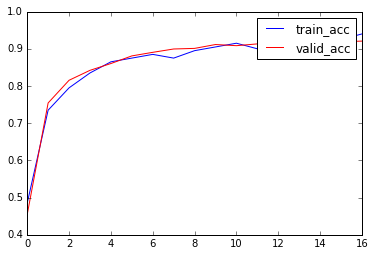

In [9]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()

# Online version

In [21]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [22]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

layer done
layer done
(10, ?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [23]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = [[], [], []]

for d in range(3):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if i % 50 == 0:
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        for i in range(3): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
        
        taccs.append(train_accuracy)
        print("valid accuracy %g %g %g"%(vaccs[0][-1], vaccs[1][-1], vaccs[2][-1]))

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.13
f : 202067.296875, q : 142556.53125, p : -54964.0664062, l : 4607.13037109
ep 0, batch 50, training accuracy 0.895
f : 196580.578125, q : 140581.421875, p : -55000.8632812, l : 1072.82592773
ep 0, batch 100, training accuracy 0.88
f : 194504.203125, q : 138568.75, p : -55023.9023438, l : 918.157470703
ep 0, batch 150, training accuracy 0.91
f : 192486.65625, q : 136465.421875, p : -55037.078125, l : 856.607421875
ep 0, batch 200, training accuracy 0.935
f : 190242.609375, q : 134628.640625, p : -55046.7617188, l : 559.09576416
valid accuracy 0.9127 0.096 0.0894
ep 1, batch 0, training accuracy 0.955
f : 188444.5, q : 132722.5, p : -55054.328125, l : 673.783569336
ep 1, batch 50, training accuracy 0.945
f : 186205.765625, q : 130687.492188, p : -55060.4570312, l : 449.354309082
ep 1, batch 100, training accuracy 0.935
f : 184398.9375, q : 128593.414062, p : -55066.9296875, l : 573.63684082
ep 1, batch 150, training accuracy 0.945
f : 182425.75, q : 

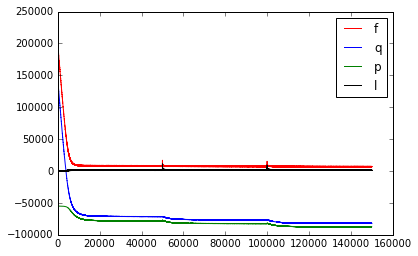

In [24]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

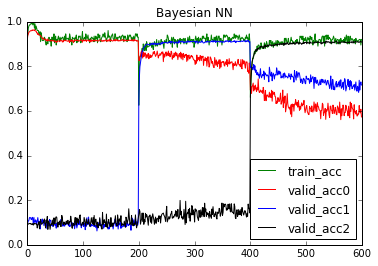

In [25]:
plt.title('Bayesian NN')
plt.plot(taccs, 'g')
plt.plot(vaccs[0], 'r')
plt.plot(vaccs[1], 'b')
plt.plot(vaccs[2], 'k')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2'],loc = 4)
plt.show()

#Online version + EWC with rho_grad

In [16]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [17]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

layer done
layer done
(10, ?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [18]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = [[], [], []]

for d in range(3):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if i % 50 == 0:
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        if ep % 50 == 0: bnn.print_ewcgrads(feed)
        
        for i in range(3): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
        
        taccs.append(train_accuracy)
        print("valid accuracy %g %g %g"%(vaccs[0][-1], vaccs[1][-1], vaccs[2][-1]))

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.13
f : 202064.703125, q : 142556.53125, p : -54964.0507812, l : 4604.203125
ep 0, batch 50, training accuracy 0.685
f : 198390.640625, q : 140581.46875, p : -54970.4882812, l : 2912.6796875
ep 0, batch 100, training accuracy 0.805
f : 195297.53125, q : 138568.90625, p : -54986.2851562, l : 1751.24182129
ep 0, batch 150, training accuracy 0.815
f : 192986.046875, q : 136465.625, p : -54997.7539062, l : 1392.44702148
ep 0, batch 200, training accuracy 0.895
f : 190448.40625, q : 134628.984375, p : -55006.4257812, l : 805.47277832
layer0/q_pos/mu:0
max: 4.88245344162, min: -5.29063034058, mean: 0.011373792775, std: 0.674753129482
layer0/q_pos/rho:0
max: -0.919796705246, min: -1.09401786327, mean: -0.99560880661, std: 0.00596338510513
layer1/q_pos/mu:0
max: 10.850810051, min: -12.3151454926, mean: -0.000259738822933, std: 3.09510016441
layer1/q_pos/rho:0
max: -0.831258952618, min: -1.12210392952, mean: -0.994824826717, std: 0.0272363778204
valid accuracy 

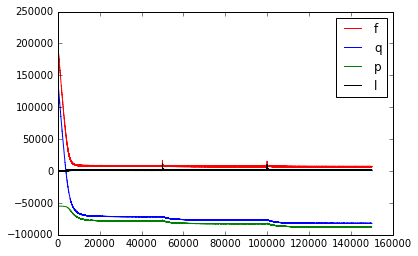

In [19]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

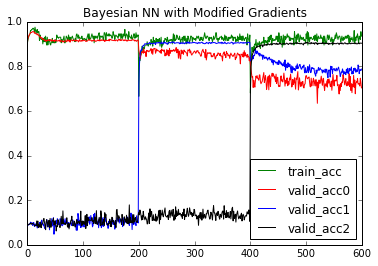

In [20]:
plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs, 'g')
plt.plot(vaccs[0], 'r')
plt.plot(vaccs[1], 'b')
plt.plot(vaccs[2], 'k')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2'], loc = 4)
plt.show()

#Normal NN

In [29]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [30]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = True, ewc = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

layer done
layer done
(?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [31]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = [[], [], []]

for d in range(3):
    nn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {nn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    nn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = nn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            nn.train(feed)

            if i % 50 == 0:
                train_accuracy = nn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = nn.get_lr()
                nn.decay_lr()
                patience = 3

                if nn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        for i in range(3): 
            vaccs[i].append(nn.validate({nn.x: x_valid[i], nn.t: t_valid}))
        
        taccs.append(train_accuracy)
        print("valid accuracy %g %g %g"%(vaccs[0][-1], vaccs[1][-1], vaccs[2][-1]))

        summary = sess.run(merged, feed_dict ={nn.x: x_valid[d], nn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    nn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.13
ep 0, batch 50, training accuracy 0.39
ep 0, batch 100, training accuracy 0.425
ep 0, batch 150, training accuracy 0.62
ep 0, batch 200, training accuracy 0.755
valid accuracy 0.8003 0.0938 0.1097
ep 1, batch 0, training accuracy 0.79
ep 1, batch 50, training accuracy 0.835
ep 1, batch 100, training accuracy 0.82
ep 1, batch 150, training accuracy 0.815
ep 1, batch 200, training accuracy 0.86
valid accuracy 0.8826 0.0844 0.112
ep 2, batch 0, training accuracy 0.87
ep 2, batch 50, training accuracy 0.88
ep 2, batch 100, training accuracy 0.865
ep 2, batch 150, training accuracy 0.84
ep 2, batch 200, training accuracy 0.88
valid accuracy 0.901 0.0833 0.1042
ep 3, batch 0, training accuracy 0.905
ep 3, batch 50, training accuracy 0.9
ep 3, batch 100, training accuracy 0.875
ep 3, batch 150, training accuracy 0.845
ep 3, batch 200, training accuracy 0.89
valid accuracy 0.9104 0.0836 0.0961
ep 4, batch 0, training accuracy 0.915
ep 4, batch 50, training

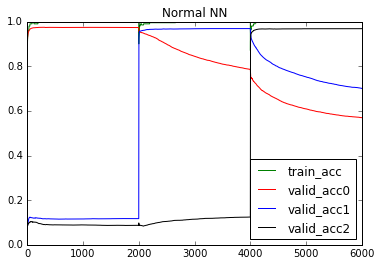

In [32]:
taccs_nNN = taccs
vaccs_nNN = vaccs

plt.title('Normal NN')
plt.plot(taccs_nNN, 'g')
plt.plot(vaccs_nNN[0], 'r')
plt.plot(vaccs_nNN[1], 'b')
plt.plot(vaccs_nNN[2], 'k')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2'], loc = 4)
plt.show()

#Normal NN + EWC

In [33]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

layer done
layer done
(?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = [[], [], []]

for d in range(3):
    enn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {enn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    enn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = enn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            enn.train(feed)

            if i % 50 == 0:
                train_accuracy = enn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = enn.get_lr()
                enn.decay_lr()
                patience = 3

                if enn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        for i in range(3): 
            vaccs[i].append(enn.validate({enn.x: x_valid[i], enn.t: t_valid}))
        
        taccs.append(train_accuracy)
        print("valid accuracy %g %g %g"%(vaccs[0][-1], vaccs[1][-1], vaccs[2][-1]))

        summary = sess.run(merged, feed_dict ={enn.x: x_valid[d], enn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    enn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.105
ep 0, batch 50, training accuracy 0.395
ep 0, batch 100, training accuracy 0.345
ep 0, batch 150, training accuracy 0.52
ep 0, batch 200, training accuracy 0.63
valid accuracy 0.6224 0.1426 0.204
ep 1, batch 0, training accuracy 0.625
ep 1, batch 50, training accuracy 0.62
ep 1, batch 100, training accuracy 0.65
ep 1, batch 150, training accuracy 0.67
ep 1, batch 200, training accuracy 0.705
valid accuracy 0.7231 0.1411 0.1927
ep 2, batch 0, training accuracy 0.71
ep 2, batch 50, training accuracy 0.68
ep 2, batch 100, training accuracy 0.685
ep 2, batch 150, training accuracy 0.69
ep 2, batch 200, training accuracy 0.73
valid accuracy 0.7624 0.1502 0.197
ep 3, batch 0, training accuracy 0.73
ep 3, batch 50, training accuracy 0.725
ep 3, batch 100, training accuracy 0.725
ep 3, batch 150, training accuracy 0.72
ep 3, batch 200, training accuracy 0.755
valid accuracy 0.792 0.1441 0.1887
ep 4, batch 0, training accuracy 0.77
ep 4, batch 50, training

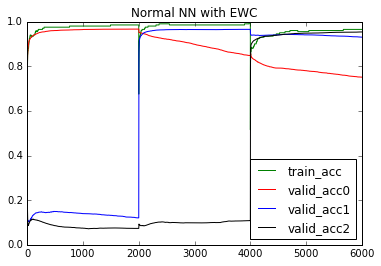

In [37]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'g')
plt.plot(vaccs_NNEWC[0], 'r')
plt.plot(vaccs_NNEWC[1], 'b')
plt.plot(vaccs_NNEWC[2], 'k')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2'], loc = 4)
plt.show()